In [1]:
import numpy as np

import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import arviz as az

import torch
import torch.nn as nn
import torch.optim as optim

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample


from models import deconvolution


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = 'cpu'

torch.set_default_device(device)


/home/akseli/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Inverse problem 

In [2]:
# Parameters
T = 0.05
N = 100
domain = [0, 1]
sigma_noise = 0.05
mu_u = -1
sigma_2_u = 0.05**2

n = 2*N
t = np.linspace(domain[0],domain[1], N)
t = np.round(t, 3)
d_k = 40

h = domain[1] / N

params = [0, 2.0, 0.2, 1.0, 0]

def problem_system(grid: np.array, params)-> np.array:

    output = np.zeros(grid.shape)
    for idx, point in enumerate(grid):
        if point <= 0.1:
            output[idx] = params[0]
        elif point <= 0.2:
            output[idx] = params[1]
        elif point <= 0.4:
            output[idx] = params[2]
        elif point <= 0.75:
            #output[idx] = params[3]
            output[idx] = 0.3*np.sin(2*np.pi*point*2)+params[3]
        else:
            output[idx] = point*params[4]
    
    return output



## Convolution matrix

In [3]:
model = deconvolution(int(np.round(n/2)), int(n/16), 'reflect')
A = model.linear_operator(n)
A = A[1::2, :]

#A[0,0] = 0
#A[-1, -1] = 0

## Data Generation

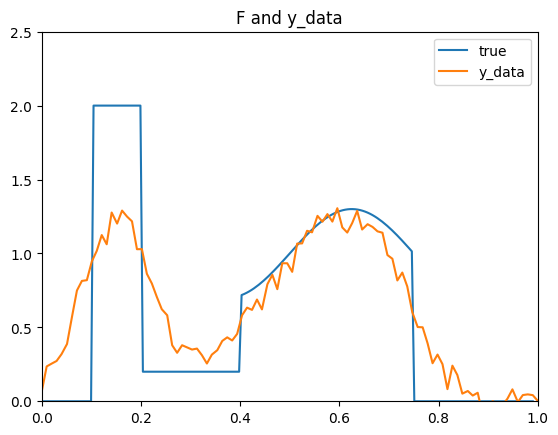

In [4]:
# Generate grid points
x = np.linspace(0, domain[1] - h, n)

# Construct the function f
f = problem_system(x, params)
#f = np.sin(10*x-0.2)
f = A@f
ind = f > 0
f *= ind

# Create y_data with noise
y_data = f + np.random.normal(0, sigma_noise, f.shape)

f = problem_system(x, params)

# Plot f and w
plt.figure()
plt.plot(x, f, label='true')
plt.plot(t, y_data, label='y_data')
plt.axis([domain[0], domain[1], 0, 2.5])
plt.title('F and y_data')
plt.legend()
plt.show()

Old targets

## Pyro BNN

In [5]:
'''
Cauchy-jakaumia BNN:ään. 

'''

class BNN(PyroModule):

    def __init__(self, h1, h2):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](h1, h2)
        self.fc1.weight = PyroSample(dist.Normal(0.5,
                                                torch.tensor(0.5)).expand([h2, h1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.5)).expand([h2]).to_event(1))
        
        #self.fc1 = nn.Linear(h1, h2)

        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Cauchy(0.5,
                                                torch.tensor(0.5)).expand([h2, h2]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.05)).expand([h2]).to_event(1))

        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        
        x = x#.reshape(-1, 1)

        x = self.relu(self.fc1(x))#.squeeze()
        mu = self.relu(self.fc2(x))
        #mu = x
        sigma = pyro.sample("sigma", dist.Uniform(0.,
                                                torch.tensor(1.0)))
    
        with pyro.plate("bnn", 200):
            obs = pyro.sample("bnn_obs", dist.Normal(mu, sigma), obs=y)
        
        return mu


In [6]:
# Convert data to PyTorch tensors
x_train = torch.from_numpy(t).float()
y_train = torch.from_numpy(y_data).float()


## Sampling with NUTS

In [72]:
import torch
import pyro
import pyro.distributions as dist
import pyro.infer


A = torch.tensor(A, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)

# Define the model in Pyro
def inverse_model(A, y_data):
    n = A.size(1)  # Number of features
    
    # Priors for the weights (omega)
    #omega = pyro.sample("omega", dist.Normal(1, 1).expand([n]).to_event(1))
        
    # Prior for the standard deviation of the noise
    sigma = pyro.sample("s", dist.Normal(0, 0.05))

    bnn_model = BNN(h1=N, h2=n)
    
    # Linear model
    mu = A @ bnn_model(y_data)
    
    # Likelihood (sampling distribution) of observations
    with pyro.plate("dd", len(y_data)):
        obs = pyro.sample("obs", dist.Cauchy(mu, sigma), obs=y_data)


# Define the NUTS sampler
inverse_nuts_kernel = pyro.infer.NUTS(inverse_model)
mcmc = pyro.infer.MCMC(inverse_nuts_kernel, num_samples=10, warmup_steps=20)

# Run MCMC
mcmc.run(A, y_data)

# Extract samples
posterior_samples = mcmc.get_samples()

# Analyze the results
alpha_samples = posterior_samples['omega'].numpy()
sigma_samples = posterior_samples['sigma'].numpy()


/tmp/ipykernel_3282395/3312078550.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A, dtype=torch.float32)
/tmp/ipykernel_3282395/3312078550.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y_data, dtype=torch.float32)
Sample: 100%|██████████| 30/30 [05:45, 11.53s/it, step size=4.73e-03, acc. prob=0.041]


KeyError: 'omega'

In [74]:
predictive = pyro.infer.Predictive(model=inverse_model, posterior_samples=mcmc.get_samples())

preds = predictive(A, y_data)

ValueError: Expected parameter scale (Tensor of shape (100,)) of distribution Cauchy(loc: torch.Size([100]), scale: torch.Size([100])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([-0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093,
        -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093,
        -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093,
        -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093,
        -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093,
        -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093,
        -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093,
        -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093,
        -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093,
        -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093,
        -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093,
        -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093, -0.0093,
        -0.0093, -0.0093, -0.0093, -0.0093])
  Trace Shapes:              
   Param Sites:              
  Sample Sites:              
         s dist     |        
          value     |        
fc1.weight dist     | 200 100
          value     | 200 100
  fc1.bias dist     | 200    
          value     | 200    
fc2.weight dist     | 200 200
          value     | 200 200
  fc2.bias dist     | 200    
          value     | 200    
     sigma dist     |        
          value     |        
       bnn dist     |        
          value 200 |        
   bnn_obs dist 200 |        
          value 200 |        
        dd dist     |        
          value 100 |        

In [68]:
a = posterior_samples['bnn_obs']

In [70]:
pyro_omega = np.mean(alpha_samples, axis=0)
pyro_omega.shape

NameError: name 'alpha_samples' is not defined

Text(0.5, 1.0, 'Setup of the problem')

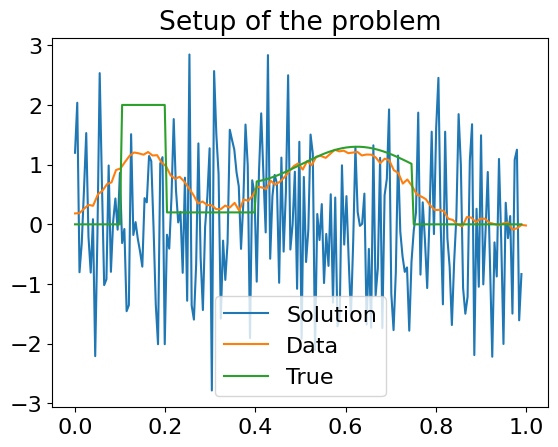

In [71]:
plt.plot(x, np.mean(a.numpy(), axis=0))
plt.plot(t, y_data)
plt.plot(x, f)
plt.legend(['Solution', 'Data', 'True'])
plt.title('Setup of the problem')
#plt.savefig('../plot_from_dev/working_gaussian.png')

# Fitting BNN to different signals and learning parameters